In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')

# Parameters
input_shape = (224, 224, 3)
num_classes = 15
batch_size = 32
epochs = 10
train_datset_dir = '../Bio2/PlantVillage'

# Data Generators
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=1./255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_datset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_datset_dir,
    target_size=(input_shape[0], input_shape[1]),
    batch_size=batch_size,
    subset='validation'
)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.applications import VGG16, DenseNet121, InceptionV3, MobileNet

# Function to create model
def create_model(base_model):
    base_model.trainable = False
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.inputs, outputs=x)
    return model

# Function to calculate F1 score
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()
    
    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)
    
    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))
    
    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Metrics
metrics = ['accuracy', Recall(), Precision(), F1Score()]

Found 16516 images belonging to 15 classes.
Found 4122 images belonging to 15 classes.


In [8]:
# MobileNet
mobilenet = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)
model_mobilenet = create_model(mobilenet)
model_mobilenet.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=metrics)
model_mobilenet.fit(train_generator, validation_data=validation_generator, epochs=epochs)
model_mobilenet.evaluate(validation_generator)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 236s 448ms/step - accuracy: 0.6578 - f1_score: 0.6615 - loss: 2.7143 - precision: 0.6966 - recall_8: 0.6303 - val_accuracy: 0.8518 - val_f1_score: 0.8568 - val_loss: 0.5059 - val_precision: 0.8754 - val_recall_8: 0.8389
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 441ms/step - accuracy: 0.8993 - f1_score: 0.8999 - loss: 0.3540 - precision: 0.9109 - recall_8: 0.8893 - val_accuracy: 0.8891 - val_f1_score: 0.8919 - val_loss: 0.4045 - val_precision: 0.9034 - val_recall_8: 0.8806
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 229s 441ms/step - accuracy: 0.9330 - f1_score: 0.9338 - loss: 0.2205 - precision: 0.9391 - recall_8: 0.9285 - val_accuracy: 0.9187 - val_f1_score: 0.9194 - val_loss: 0.2951 - val_precision: 0.9287 - val_recall_8: 0.9102
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 230s 442ms/step - accuracy: 0.9515 - f1_score: 0.9524 - loss: 0.1533 - precision: 0.9559 - recall_8: 0.9489 - val_accuracy: 0.9129 - val_f1_score: 0.9135 - val_loss: 0.3009 - val_p

[0.24526646733283997,
 0.9383794069290161,
 0.9364386200904846,
 0.9416930675506592,
 0.9390584826469421]

In [2]:
# AlexNet (Using VGG16 as a proxy)
alexnet = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
model_alexnet = create_model(alexnet)
model_alexnet.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=metrics)
model_alexnet.fit(train_generator, validation_data=validation_generator, epochs=epochs)
model_alexnet.evaluate(validation_generator)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 1351s 3s/step - accuracy: 0.6121 - f1_score: 0.5783 - loss: 1.3020 - precision: 0.8020 - recall: 0.4705 - val_accuracy: 0.8552 - val_f1_score: 0.8543 - val_loss: 0.4392 - val_precision: 0.8905 - val_recall: 0.8210
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 792s 2s/step - accuracy: 0.8604 - f1_score: 0.8611 - loss: 0.4041 - precision: 0.8961 - recall: 0.8287 - val_accuracy: 0.8714 - val_f1_score: 0.8732 - val_loss: 0.3696 - val_precision: 0.8963 - val_recall: 0.8513
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 801s 2s/step - accuracy: 0.8960 - f1_score: 0.8959 - loss: 0.3056 - precision: 0.9170 - recall: 0.8757 - val_accuracy: 0.8901 - val_f1_score: 0.8900 - val_loss: 0.3136 - val_precision: 0.9094 - val_recall: 0.8714
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 796s 2s/step - accuracy: 0.9026 - f1_score: 0.9048 - loss: 0.2865 - precision: 0.9208 - recall: 0.8894 - val_accuracy: 0.8816 - val_f1_score: 0.8818 - val_loss: 0.3445 - val_precision: 0.8953 - val_re

[0.33263343572616577,
 0.9012615084648132,
 0.8978651165962219,
 0.9102311730384827,
 0.904005765914917]

In [3]:
# InceptionV3
inception = InceptionV3(weights='imagenet', include_top=False, input_shape=input_shape)
model_inception = create_model(inception)
model_inception.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=metrics)
model_inception.fit(train_generator, validation_data=validation_generator, epochs=epochs)
model_inception.evaluate(validation_generator)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 4386s 8s/step - accuracy: 0.4155 - f1_score: 0.6534 - loss: 4.0036 - precision: 0.8103 - recall: 0.5516 - val_accuracy: 0.6405 - val_f1_score: 0.6481 - val_loss: 1.1140 - val_precision: 0.7874 - val_recall: 0.5507
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 262s 505ms/step - accuracy: 0.6996 - f1_score: 0.7027 - loss: 0.9429 - precision: 0.7945 - recall: 0.6300 - val_accuracy: 0.7635 - val_f1_score: 0.7571 - val_loss: 0.7064 - val_precision: 0.8444 - val_recall: 0.6861
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 261s 503ms/step - accuracy: 0.7899 - f1_score: 0.7936 - loss: 0.6211 - precision: 0.8465 - recall: 0.7470 - val_accuracy: 0.8020 - val_f1_score: 0.7980 - val_loss: 0.5762 - val_precision: 0.8382 - val_recall: 0.7615
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 0.8280 - f1_score: 0.8264 - loss: 0.5076 - precision: 0.8647 - recall: 0.7913 - val_accuracy: 0.8372 - val_f1_score: 0.8386 - val_loss: 0.5071 - val_precision: 0.8723 - 

[0.37472283840179443,
 0.8765162825584412,
 0.8653566241264343,
 0.8953313231468201,
 0.880088746547699]

In [4]:
# DenseNet121
dn = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
model_densenet = create_model(dn)
model_densenet.compile(optimizer=Adam(), loss=CategoricalCrossentropy(from_logits=True), metrics=metrics)
model_densenet.fit(train_generator, validation_data=validation_generator, epochs=epochs)
model_densenet.evaluate(validation_generator)

Epoch 1/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 460s 867ms/step - accuracy: 0.4468 - f1_score: 0.6506 - loss: 3.2332 - precision: 0.8310 - recall: 0.5383 - val_accuracy: 0.7829 - val_f1_score: 0.7787 - val_loss: 0.6730 - val_precision: 0.8512 - val_recall: 0.7176
Epoch 2/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 461s 888ms/step - accuracy: 0.8098 - f1_score: 0.8151 - loss: 0.5830 - precision: 0.8692 - recall: 0.7676 - val_accuracy: 0.8508 - val_f1_score: 0.8507 - val_loss: 0.4563 - val_precision: 0.8835 - val_recall: 0.8202
Epoch 3/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 508s 981ms/step - accuracy: 0.8788 - f1_score: 0.8822 - loss: 0.3642 - precision: 0.9086 - recall: 0.8572 - val_accuracy: 0.8743 - val_f1_score: 0.8761 - val_loss: 0.3534 - val_precision: 0.8960 - val_recall: 0.8571
Epoch 4/10
517/517 ━━━━━━━━━━━━━━━━━━━━ 726s 1s/step - accuracy: 0.8964 - f1_score: 0.8982 - loss: 0.2999 - precision: 0.9150 - recall: 0.8821 - val_accuracy: 0.8850 - val_f1_score: 0.8865 - val_loss: 0.3554 - val_precision: 0.9017 

[0.2150925099849701,
 0.9337700009346008,
 0.9315866231918335,
 0.9379580020904541,
 0.9347614049911499]

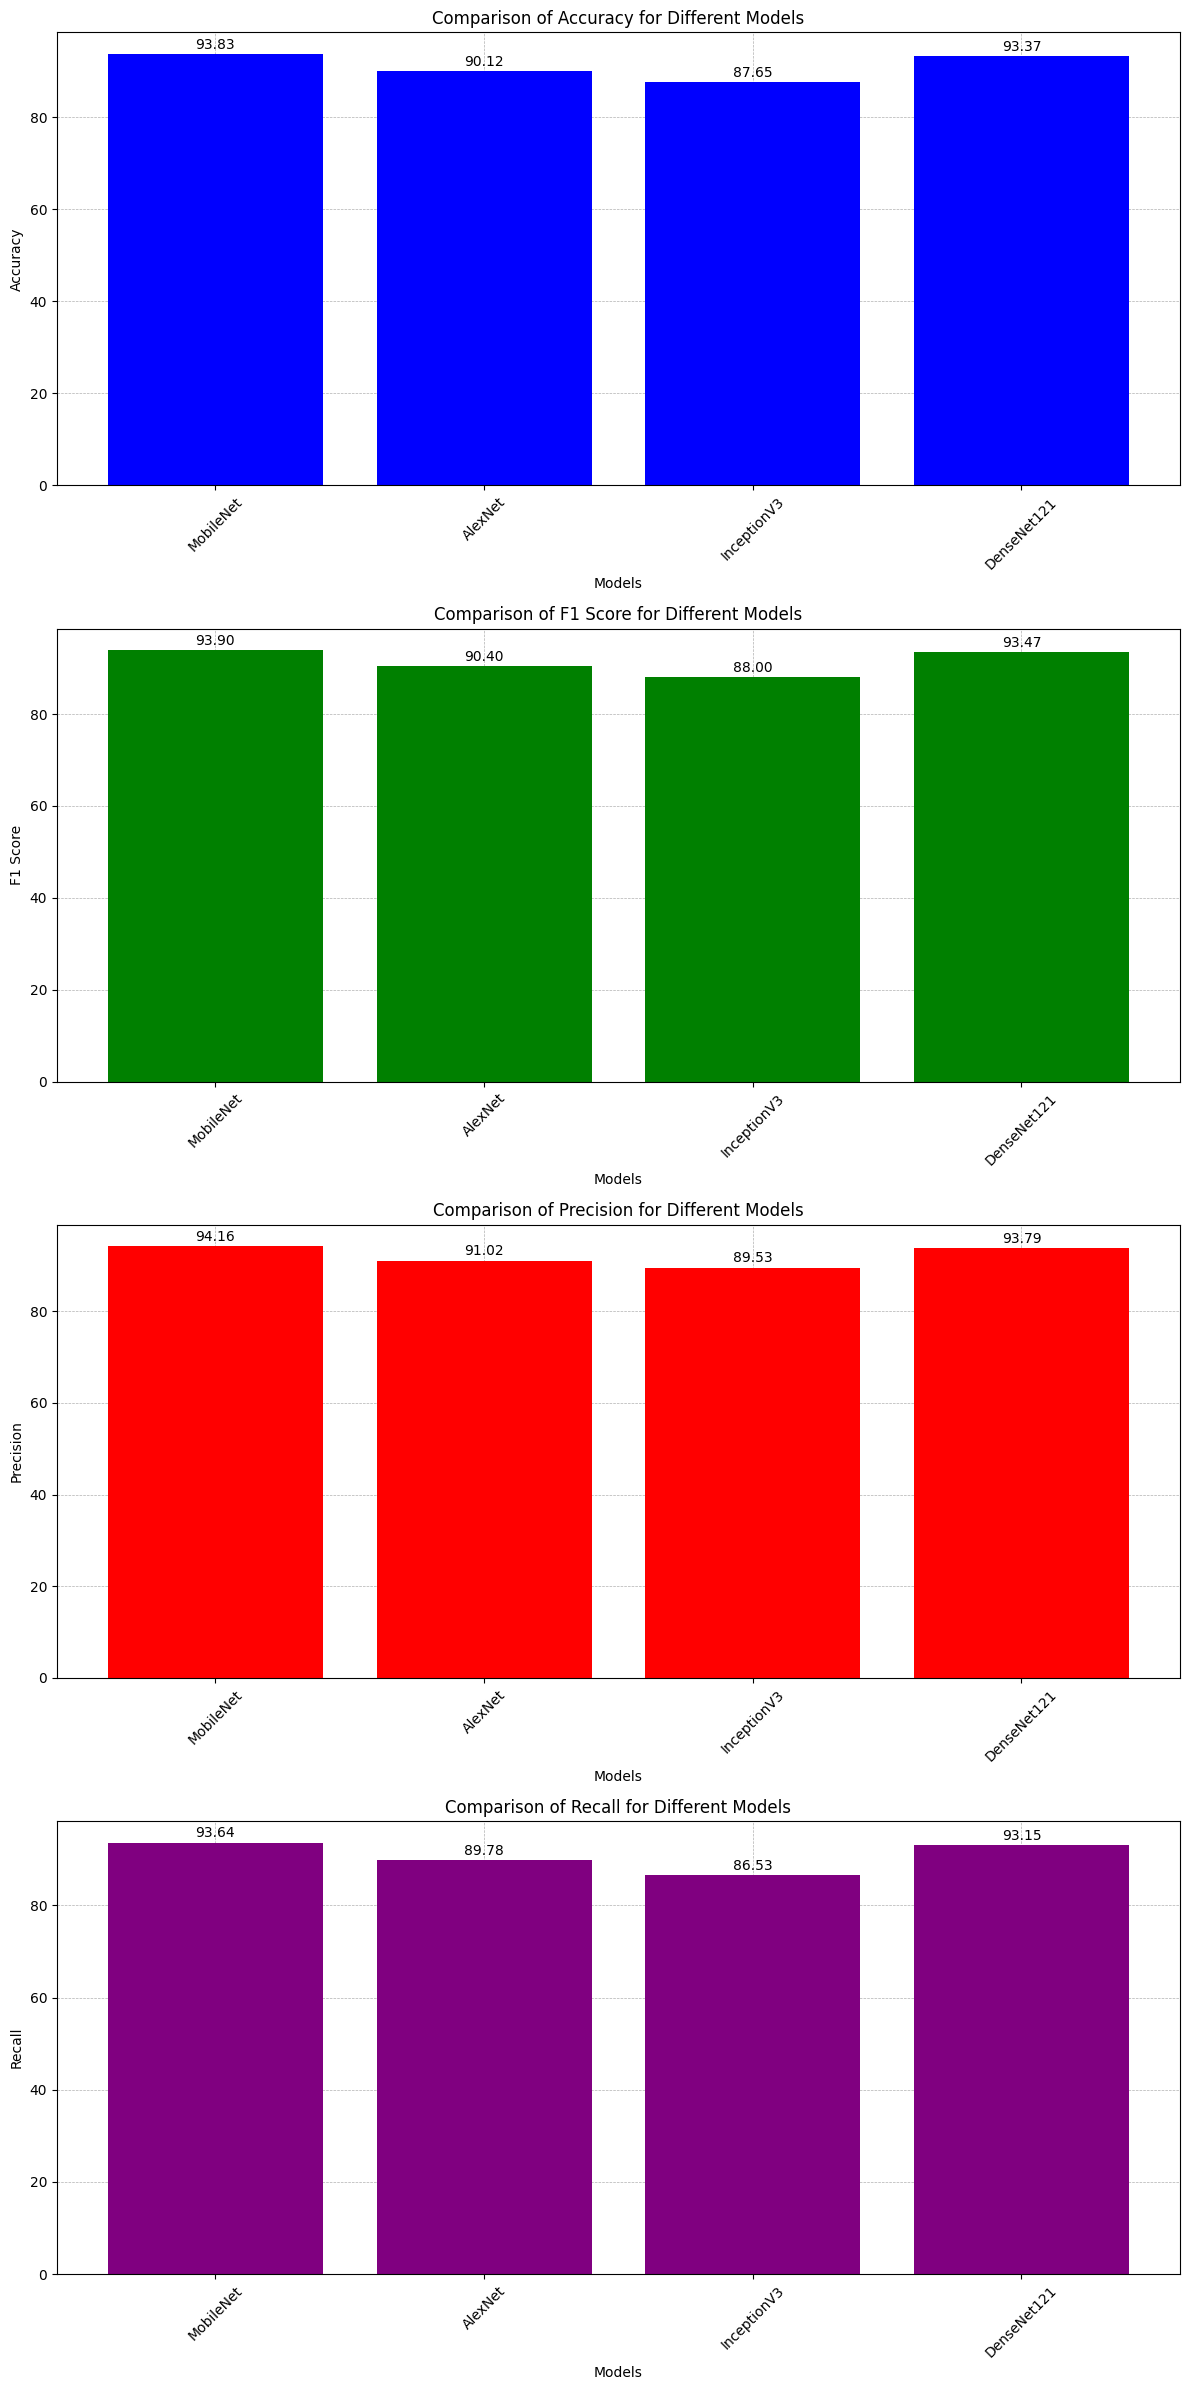

In [5]:
import matplotlib.pyplot as plt

# Updated results for the five models
results = {
    'MobileNet': {'Accuracy': 93.83, 'F1Score': 93.90, 'Precision': 94.16, 'Recall': 93.64},
    'AlexNet': {'Accuracy': 90.12, 'F1Score': 90.40, 'Precision': 91.02, 'Recall': 89.78},
    'InceptionV3': {'Accuracy': 87.65, 'F1Score': 88.00, 'Precision': 89.53, 'Recall': 86.53},
    'DenseNet121': {'Accuracy': 93.37, 'F1Score': 93.47, 'Precision': 93.79, 'Recall': 93.15}
}

# Add models and metrics
models = list(results.keys())
accuracy_values = [results[model]['Accuracy'] for model in models]
f1_values = [results[model]['F1Score'] for model in models]
precision_values = [results[model]['Precision'] for model in models]
recall_values = [results[model]['Recall'] for model in models]

# Create subplots for Accuracy, F1 Score, Precision, and Recall
fig, axes = plt.subplots(4, 1, figsize=(12, 24))

# Accuracy plot
axes[0].bar(models, accuracy_values, color='blue')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_title('Comparison of Accuracy for Different Models')
axes[0].set_xticks(range(len(models)))
axes[0].set_xticklabels(models, rotation=45)
axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[0].set_axisbelow(True)
for i in range(len(models)):
    axes[0].text(i, accuracy_values[i] + 0.5, f'{accuracy_values[i]:.2f}', ha='center', va='bottom')

# F1 Score plot
axes[1].bar(models, f1_values, color='green')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('F1 Score')
axes[1].set_title('Comparison of F1 Score for Different Models')
axes[1].set_xticks(range(len(models)))
axes[1].set_xticklabels(models, rotation=45)
axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[1].set_axisbelow(True)
for i in range(len(models)):
    axes[1].text(i, f1_values[i] + 0.5, f'{f1_values[i]:.2f}', ha='center', va='bottom')

# Precision plot
axes[2].bar(models, precision_values, color='red')
axes[2].set_xlabel('Models')
axes[2].set_ylabel('Precision')
axes[2].set_title('Comparison of Precision for Different Models')
axes[2].set_xticks(range(len(models)))
axes[2].set_xticklabels(models, rotation=45)
axes[2].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[2].set_axisbelow(True)
for i in range(len(models)):
    axes[2].text(i, precision_values[i] + 0.5, f'{precision_values[i]:.2f}', ha='center', va='bottom')

# Recall plot
axes[3].bar(models, recall_values, color='purple')
axes[3].set_xlabel('Models')
axes[3].set_ylabel('Recall')
axes[3].set_title('Comparison of Recall for Different Models')
axes[3].set_xticks(range(len(models)))
axes[3].set_xticklabels(models, rotation=45)
axes[3].grid(True, which='both', linestyle='--', linewidth=0.5)
axes[3].set_axisbelow(True)
for i in range(len(models)):
    axes[3].text(i, recall_values[i] + 0.5, f'{recall_values[i]:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()
